In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import gym
from gym import spaces
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

In [26]:
class Grid3DEnv(gym.Env):
    def __init__(self, grid_size, R):
        super(Grid3DEnv, self).__init__()
        self.grid_size = np.array(grid_size)
        self.state = None
        self.start = np.array([0, 0, 0])
        self.goal = np.array([grid_size[0] - 1, grid_size[1] - 1, grid_size[2] - 1])
        self.obstacles = set()
        self.obs_radius = 2  # 观测半径
        self.R = R  # 前进半径
        self.movements = self._generate_movements(R)
        self.action_space = spaces.Discrete(len(self.movements))  # 动作空间大小取决于可能的移动动作数量
        self.observation_space = spaces.Box(low=0, high=1, shape=(
            2 * self.obs_radius + 1, 2 * self.obs_radius + 1, 2 * self.obs_radius + 1), dtype=np.float32)
        self.prev_action = None
        self.movement_cost=0
        self.safety_risk=0
        self.num=0
        

    def _generate_movements(self, R):
        movements = []
        for dx in range(-R, R + 1):
            for dy in range(-R, R + 1):
                for dz in range(-R, R + 1):
                    if dx == 0 and dy == 0 and dz == 0:
                        continue
                    movements.append(np.array([dx, dy, dz]))
        return movements

    def _generate_obstacles(self):
        num_obstacles = np.random.randint(1, int(self.grid_size[0] * self.grid_size[1] * self.grid_size[2] * 0.05))
        obstacles = set()
        while len(obstacles) < num_obstacles:
            obstacle = tuple(np.random.randint(0, size) for size in self.grid_size)
            if obstacle != tuple(self.start) and obstacle != tuple(self.goal):
                obstacles.add(obstacle)
        return obstacles

    def reset(self):
        self.obstacles = self._generate_obstacles()
        # self.start = np.random.randint(0, self.grid_size[0], size=3)
        # self.goal = np.random.randint(0, self.grid_size[0], size=3)
        # while tuple(self.start) in self.obstacles or np.array_equal(self.start, self.goal):
        #     self.start = np.random.randint(0, self.grid_size[0], size=3)
        # while tuple(self.goal) in self.obstacles or np.array_equal(self.start, self.goal):
        #     self.goal = np.random.randint(0, self.grid_size[0], size=3)

        self.state = self.start
        self.prev_action = None
        self.safety_risk=0
        self.movement_cost=0
        self.num=0
        return self._get_observation()

    def _get_observation(self):
        x, y, z = self.state
        obs_radius = self.obs_radius
        x_min, x_max = max(0, x - obs_radius), min(self.grid_size[0], x + obs_radius + 1)
        y_min, y_max = max(0, y - obs_radius), min(self.grid_size[1], y + obs_radius + 1)
        z_min, z_max = max(0, z - obs_radius), min(self.grid_size[2], z + obs_radius + 1)

        local_view = np.zeros((2 * obs_radius + 1, 2 * obs_radius + 1, 2 * obs_radius + 1))
        for obs in self.obstacles:
            if x_min <= obs[0] < x_max and y_min <= obs[1] < y_max and z_min <= obs[2] < z_max:
                local_view[obs[0] - x_min, obs[1] - y_min, obs[2] - z_min] = -10
        if x_min <= self.goal[0] < x_max and y_min <= self.goal[1] < y_max and z_min <= self.goal[2] < z_max:
            local_view[self.goal[0] - x_min, self.goal[1] - y_min, self.goal[2] - z_min] = 20

        # Including current position index
        position_index = x * self.grid_size[1] * self.grid_size[2] + y * self.grid_size[2] + z
        return np.append(local_view.flatten(), position_index)

    def compute_normalized_goal_distance(self):
        distance = np.linalg.norm(self.state - self.goal)
        normalized_distance = 1 / distance if distance != 0 else 300
        return normalized_distance
    def step(self, action):
        next_state = self.state + self.movements[action]
        next_state = np.clip(next_state, [0, 0, 0], self.grid_size - 1)
        # if np.array_equal(self.state, next_state):
        #     obe_choose=10
        # else:
        #     obe_choose=0
        # # if tuple(next_state) in self.obstacles:
        # #     reward = -1000
        # #     return self._get_observation(), reward, done, self.state

        # if self.prev_action is None:
        #     movement_cost = 1
        # else:
        #     if not np.array_equal(self.movements[self.prev_action], self.movements[action]):
        #         movement_cost = 2  # 较高的转弯成本
        #     else:
        #         movement_cost = 0.5  # 较低的直线移动成本

        # relevant_obstacles = [obs for obs in self.obstacles if np.linalg.norm(self.state - obs) <= 3 * self.R]
        # safety_risk = sum([np.exp(-np.linalg.norm(next_state - np.array(obstacle))) for obstacle in relevant_obstacles])
        # self.state = next_state
        # done = np.array_equal(self.state, self.goal)
        # reward = 3000 if done else - movement_cost - safety_risk - obe_choose

        # self.prev_action = action
        # if tuple(next_state) in self.obstacles:
        #     reward = -3000
        #     done = True
        # self.safety_risk+=safety_risk
        # self.movement_cost+=movement_cost
        # self.num+=1
        done=False
            
        if self.prev_action is None:
            movement_cost = 1
        else:
            if not np.array_equal(self.movements[self.prev_action], self.movements[action]):
                movement_cost = 2  # 较高的转弯成本
            else:
                movement_cost = 0.5  # 较低的直线移动成本
        if np.array_equal(self.state, next_state):
            obe_choose=1000
            done=True
        else:
            obe_choose=0
        relevant_obstacles = [obs for obs in self.obstacles if np.linalg.norm(self.state - obs) <= 3 * self.R]
        safety_risk = sum([np.exp(-np.linalg.norm(next_state - np.array(obstacle))) for obstacle in relevant_obstacles])*10
        self.state = next_state
        r_goal_norm = self.compute_normalized_goal_distance()
        reward = - movement_cost - safety_risk - obe_choose + r_goal_norm
        if np.array_equal(self.state, self.goal):
            reward +=3000
            done = True

        self.prev_action = action
        if tuple(next_state) in self.obstacles:
            reward = -3000
            done=True
        self.safety_risk+=safety_risk
        self.movement_cost+=movement_cost
        self.num+=1
        return self._get_observation(), reward, done, self.state

    def render(self, mode='human', path=None,filename='result_q3'):
        # Create figure and 3d axis
        fig = plt.figure(figsize=(8, 6))  # 设置画布大小
        ax = fig.add_subplot(111, projection='3d')
        ax.set_facecolor('whitesmoke')  # 设置背景颜色

        # Set limits and labels
        ax.set_xlim([0, self.grid_size[0]-1])
        ax.set_ylim([0, self.grid_size[1]-1])
        ax.set_zlim([0, self.grid_size[2]-1])
        ax.set_xlabel('X-axis', fontsize=12, fontweight='bold')
        ax.set_ylabel('Y-axis', fontsize=12, fontweight='bold')
        ax.set_zlabel('Z-axis', fontsize=12, fontweight='bold')
        ax.set_title('3D Grid Environment Visualization', fontsize=16, fontweight='bold')

        # Plot obstacles
        if self.obstacles:
            obs_x, obs_y, obs_z = zip(*self.obstacles)
            ax.scatter(obs_x, obs_y, obs_z, c='darkred', marker='^', s=150, label='Obstacles', edgecolors='black')

        # Plot start and goal
        ax.scatter(*self.start, c='limegreen', marker='o', s=150, label='Start', edgecolors='black')
        ax.scatter(*self.goal, c='navy', marker='*', s=150, label='Goal', edgecolors='black')

        # Plot path if available
        if path is not None:
            path = np.array(path)
            ax.plot(path[:, 0], path[:, 1], path[:, 2], 'grey', marker='o', markersize=8, linewidth=2, label='Path')

        # Grid, legend, and show
        ax.grid(True)  # 开启网格
        ax.legend(loc='upper left', fontsize='medium', frameon=True, facecolor='white', framealpha=0.8)
        plt.tight_layout()
        plt.savefig(filename, dpi=600, bbox_inches='tight')
        plt.show()

In [27]:
class QNet(nn.Module):
    def __init__(self, input_shape, action_dim, hidden_dim=128):
        super(QNet, self).__init__()
        self.rnn = nn.LSTM(np.prod(input_shape)+1, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, action_dim)

    def forward(self, x, hx):
        x = x.view(x.size(0), 1, -1)  # Flatten the input
        x, hx = self.rnn(x, hx)
        x = x[:, -1, :]
        x = torch.relu(x)
        x = self.fc(x)
        return x, hx


class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []

    def add(self, experience):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)  # Remove the oldest experience if buffer is full
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def size(self):
        return len(self.buffer)

In [17]:
class AUVAgent:
    def __init__(self, input_shape, action_dim, hidden_dim=128, lr=0.001, buffer_capacity=10000, batch_size=64,
                 gamma=0.99, target_update=100):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.q_net = QNet(input_shape, action_dim, hidden_dim).to(self.device)
        self.target_q_net = QNet(input_shape, action_dim, hidden_dim).to(self.device)
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        self.hidden_dim = hidden_dim
        self.action_dim = action_dim
        self.replay_buffer = ReplayBuffer(buffer_capacity)
        self.batch_size = batch_size
        self.gamma = gamma
        self.target_update = target_update
        self.count = 0
        self.epsilon = 0.2

    def select_action(self, state, hx,flag=True):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)

        with torch.no_grad():
            q_values, hx = self.q_net(state_tensor, hx)
            if np.random.random() < self.epsilon and flag:
                action = np.random.randint(self.action_dim)
            else:
                action = q_values.argmax().item()
        return action, hx

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).unsqueeze(0).to(self.device)
        actions = torch.tensor(transition_dict['actions']).unsqueeze(0).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).unsqueeze(0).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).unsqueeze(0).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).unsqueeze(0).to(self.device)

        q_values, _ = self.q_net(states, hx=None)
        q_values = q_values.gather(1, actions.unsqueeze(0))

        with torch.no_grad():
            if self.count % self.target_update == 0:
                self.target_q_net.load_state_dict(self.q_net.state_dict())

            next_q_values, _ = self.target_q_net(next_states, hx=None)
            max_next_q_values = next_q_values.max(1)[0].unsqueeze(1)
            q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)

        loss = nn.functional.mse_loss(q_values, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.count += 1

    def train(self, env, num_episodes):
        return_list = []
        saft_list=[]
        move_cost_list=[]
        time_list=[]
        for episode in tqdm(range(num_episodes)):
            state = env.reset()
            episode_reward = 0
            done = False
            hx = (torch.zeros(1, 1, self.hidden_dim).to(self.device), torch.zeros(1, 1, self.hidden_dim).to(self.device))

            num=0
            while not done and num<1000:
                num+=1
                action, hx = self.select_action(state, hx)
                next_state, reward, done, _ = env.step(action)

                transition = {
                    'states': state,
                    'actions': action,
                    'rewards': reward,
                    'next_states': next_state,
                    'dones': done
                }
                self.replay_buffer.add(transition)

                if self.replay_buffer.size() >= self.batch_size:
                    batch = self.replay_buffer.sample(self.batch_size)
                    for transition in batch:
                        self.update(transition)

                state = next_state
                episode_reward += reward
            return_list.append(episode_reward)
            saft_list.append(env.safety_risk)
            move_cost_list.append(env.movement_cost)
            time_list.append(env.num)

        return return_list,saft_list,move_cost_list,time_list

    def visualize_policy(self, env):
        state = env.reset()
        done = False
        path = [env.start.copy()]
        hx = (torch.zeros(1, 1, self.hidden_dim).to(self.device), torch.zeros(1, 1, self.hidden_dim).to(self.device))
        while not done:
            action, _ = self.select_action(state, hx,False)
            next_state, reward, done, _ = env.step(action)
            path.append(_.copy())
            state = next_state

        env.render(path=path)

In [18]:
# 示例使用
R = 2  # 设置前进半径
env = Grid3DEnv(grid_size=(10, 10, 10), R=R)
agent = AUVAgent(input_shape=env.observation_space.shape, action_dim=env.action_space.n)

In [19]:
return_list,saft_list,move_cost_list,time_list = agent.train(env, num_episodes=500)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [16:20<00:00,  1.96s/it]


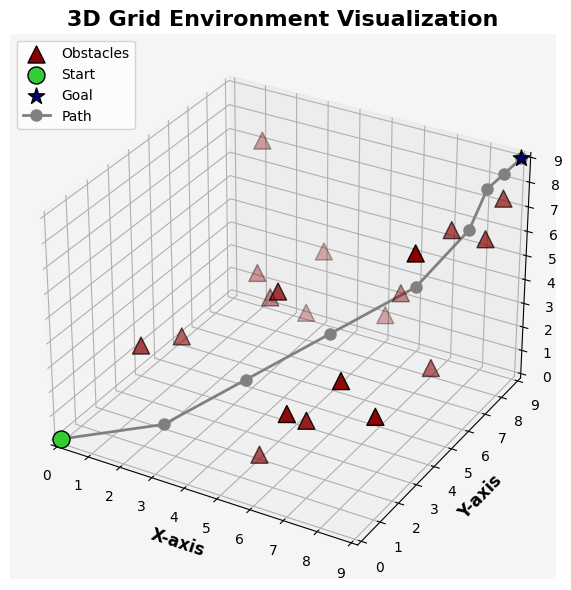

In [28]:
agent.visualize_policy(env)

In [8]:
torch.save(agent.q_net.state_dict(),"q32.pth")

In [9]:
agent.q_net.load_state_dict(torch.load("q32.pth"))

<All keys matched successfully>

In [20]:
def plot_performance(return_list,time_list, energy_list, safety_list):
    # Create figure with subplots
    fig, ((ax1, ax2), (ax3 ,ax4)) = plt.subplots(2, 2, figsize=(20, 15))

    ax1.plot(return_list, color='black', label='Return per simulation')
    ax1.set_title('Return Per simulation')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Return')
    ax1.grid(True)
    ax1.legend()
    
    # Plot Time
    ax4.plot(time_list, color='blue', label='Time per simulation')
    ax4.set_title('Time Taken Per simulation')
    ax4.set_xlabel('Iteration')
    ax4.set_ylabel('Time')
    ax4.grid(True)
    ax4.legend()

    # Plot Energy Consumption
    ax2.plot(energy_list, color='green', label='Energy per simulation')
    ax2.set_title('Energy Consumption Per simulation')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Energy')
    ax2.grid(True)
    ax2.legend()

    # Plot Safety Metric
    ax3.plot(safety_list, color='red', label='Safety Metric per simulation')
    ax3.set_title('Safety Metric Per simulation')
    ax3.set_xlabel('Iteration')
    ax3.set_ylabel('Safety Metric')
    ax3.grid(True)
    ax3.legend()

    # Show plot
    plt.tight_layout()
    plt.savefig('zb3.png', dpi=600, bbox_inches='tight')
    plt.show()

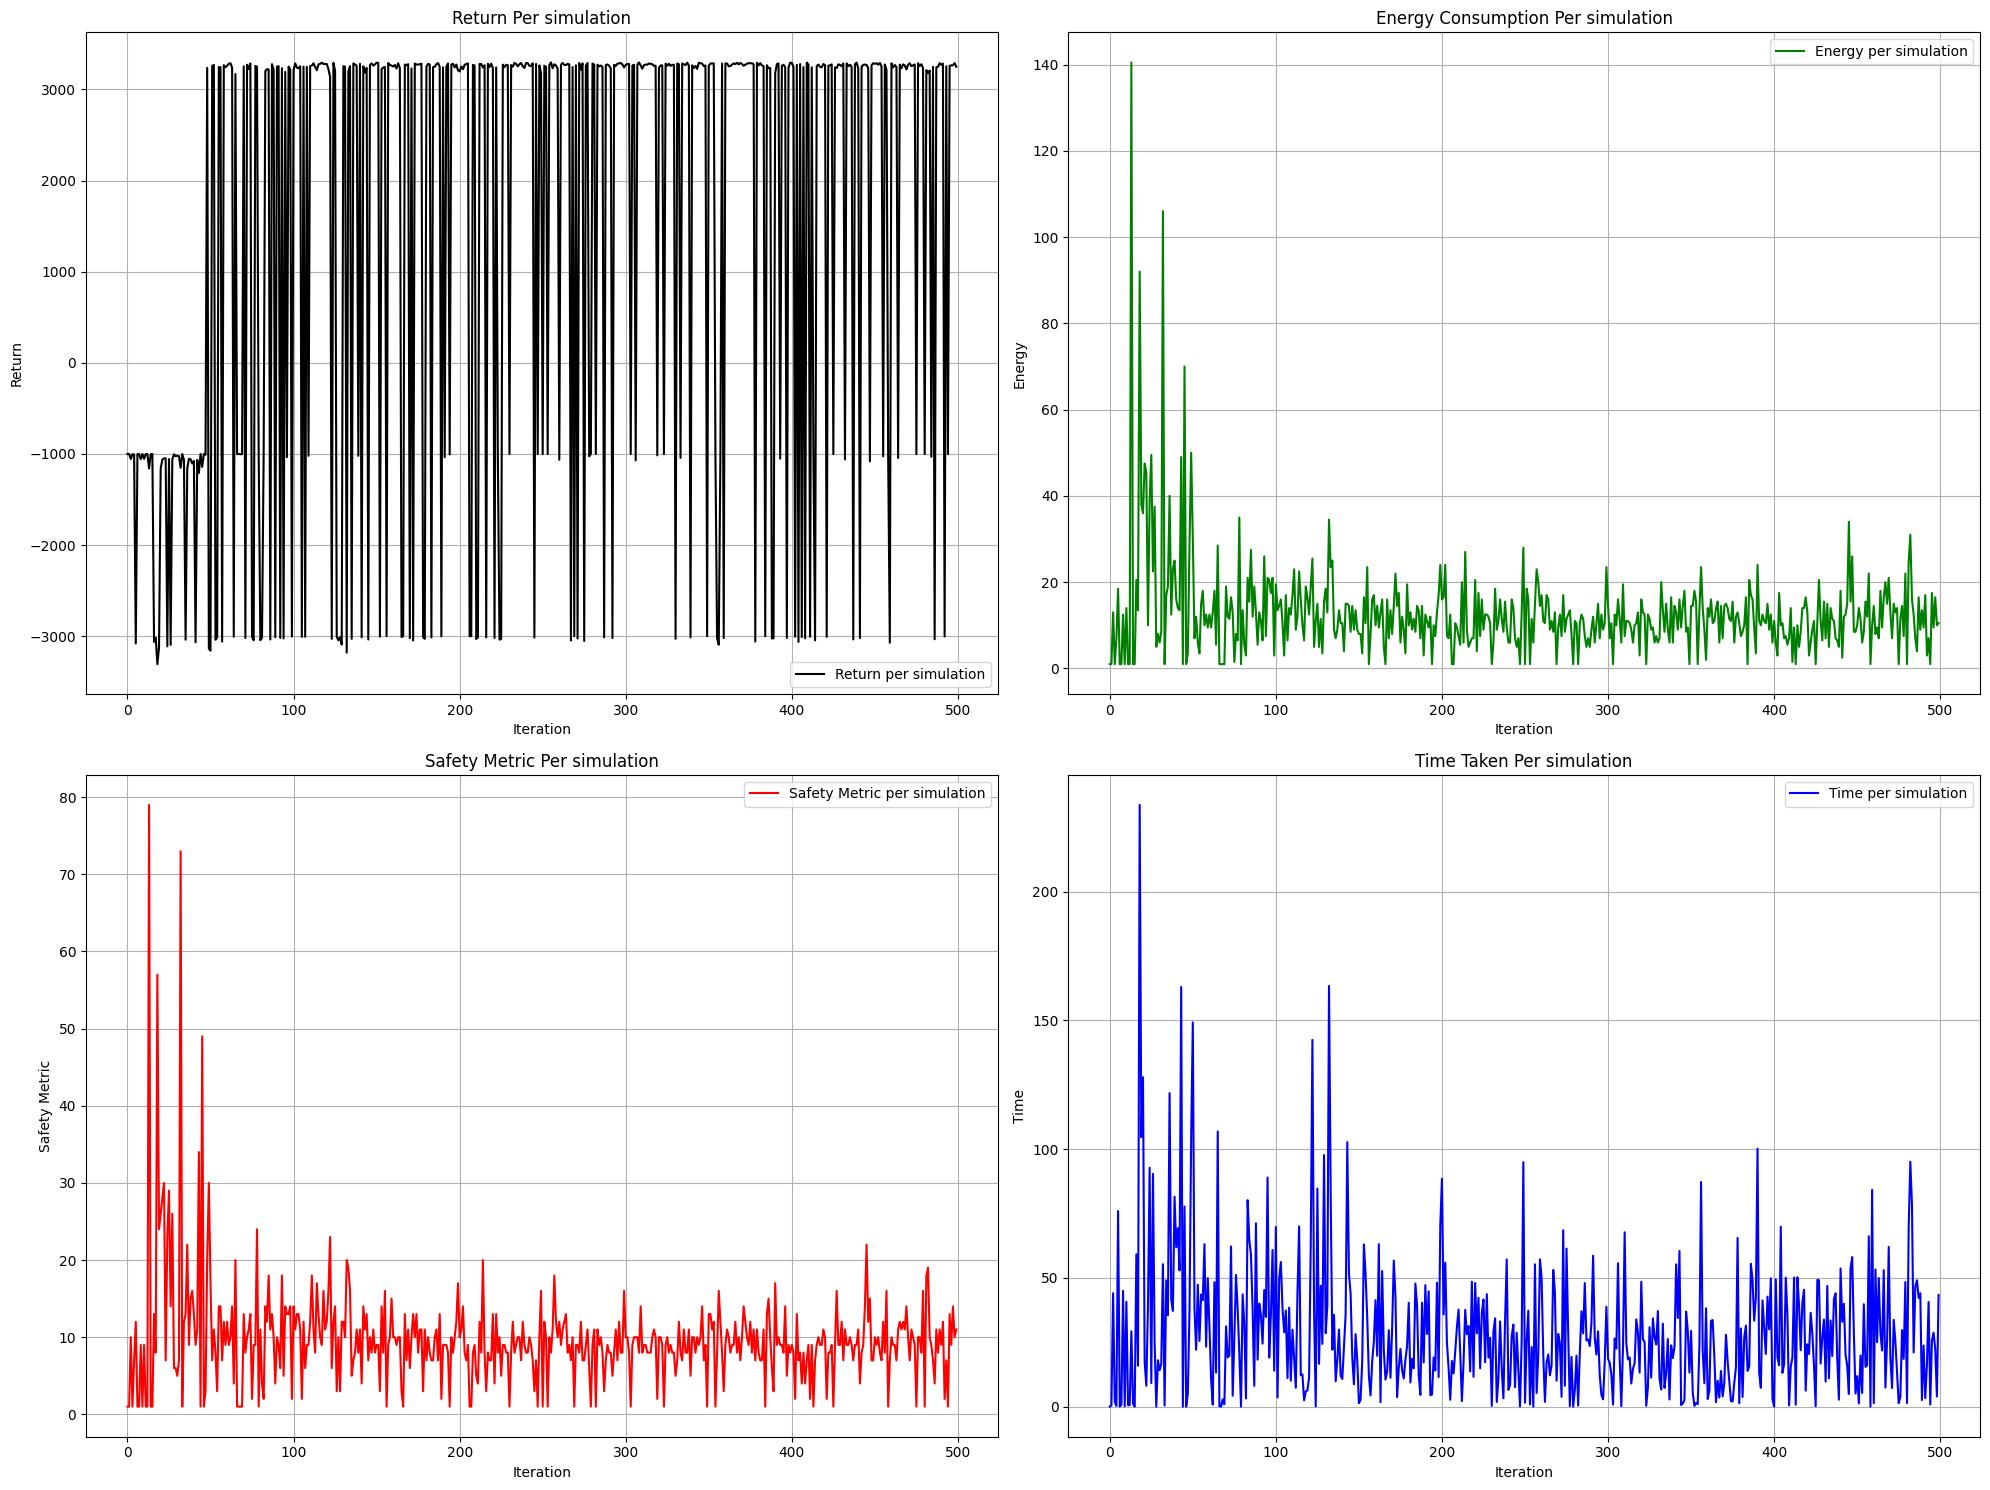

In [21]:
plot_performance(return_list,saft_list,move_cost_list,time_list)